<center>
    <img src="./images/dagang3.png" width=800>
</center>

## 4.1 简介

图像的实质是一种二维信号，滤波是信号处理中的一个重要概念。在图像处理中，滤波是一种非常常见的技术，它们的原理非常简单，但是其思想却十分值得借鉴，滤波是很多图像算法的前置步骤或基础，掌握图像滤波对理解卷积神经网络也有一定帮助。

## 4.2 图像滤波原理
<center>
    <img src="./images/conv.png" width=800>
</center>


上图蓝色点可以解释为：

$$6.5 + 9.8 + 12.3 + 6.5 + 19.2 + 11.5 + 6.3 + 9.1 + 10.7=91.9 \approx 92$$

线性滤波处理的输出像素值$g(i,j)$是输入像素值$f(i+k,j+l)$的加权和 :

$$g(i, j)=\sum_{k,l}f(i+k, j+l)h(k, l)$$


其中的加权和为 ，我们称其为“核”，滤波器的加权系数，即滤波器的“滤波系数”。
上面的式子可以简单写作：

$$g=f\otimes h$$


其中$f$表示输入像素值，$h$表示加权系数“核“，$g$表示输出像素值

### 4.4.1卷积后图像大小问题

$$⌊(n+2\times p−k+s)/s⌋ = ⌊(n+2 \times p−k)/s⌋ + 1$$ 
例：$$n=5,p=1,k=3,s=1$$
$$(n+2-3+1)/1=5$$

其中$n$为图片长（宽），$p$为padding大小，$k$为卷积核长（宽），$s$为步长

### 4.4.2填充问题

在对图像应用滤波器进行过滤时，边界问题是一个需要处理的问题。一般来说，有4种处理的方法。

1. 填充0ZeroPad2d

对图像的边界做扩展，在扩展边界中填充0，对于边长为2k+1的方形滤波器，扩展的边界大小为k，若原来的图像为[m, n]，则扩展后图像变为[m+2k, n+2k]。

2. 填充固定值ConstantPad2d
扩展与填充0的扩展类似,只不过将填充0改为填充固定值

3. 重复填充也是最邻近填充ReplicationPad2d

重复填充即重复图像的边缘像素值，将新的边界像素值用边缘像素值扩展
    
4. 镜像填充ReflectionPad2d    
nn.ReflectionPad2d()：利用输入边界的反射来填充输入张量。

其填充方式为新的dim值使用反方向的最下边元素的值

这是在风格迁移中用到的操作。镜像填充的方式相比于前面使用固定数值进行填充，有可能获得更好的卷积结果
根据边缘进行镜像对称填充

In [2]:
from torch import nn
import torch
#torch.arange,用于生成一定范围内等间隔的一维数组。参数有三个，分别是范围的起始值、范围的结束值和步长
x = torch.arange(9, dtype=torch.float).reshape(1, 1, 3, 3)
x

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

In [4]:
p = nn.ReflectionPad2d(1) #等于p = nn.ReflectionPad2d(padding=(1,1,1,1)) 四个值分别代表向左、右、上、下扩展
p(x)

tensor([[[[4., 3., 4., 5., 4.],
          [1., 0., 1., 2., 1.],
          [4., 3., 4., 5., 4.],
          [7., 6., 7., 8., 7.],
          [4., 3., 4., 5., 4.]]]])

In [5]:
p = nn.ReflectionPad2d(2)
p(x)

tensor([[[[8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.],
          [5., 4., 3., 4., 5., 4., 3.],
          [8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.]]]])

In [6]:
p = nn.ZeroPad2d(1)
p(x)

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 1., 2., 0.],
          [0., 3., 4., 5., 0.],
          [0., 6., 7., 8., 0.],
          [0., 0., 0., 0., 0.]]]])

In [8]:
p = nn.ReplicationPad2d(padding=(1,1,2,3))
p(x)

tensor([[[[0., 0., 1., 2., 2.],
          [0., 0., 1., 2., 2.],
          [0., 0., 1., 2., 2.],
          [3., 3., 4., 5., 5.],
          [6., 6., 7., 8., 8.],
          [6., 6., 7., 8., 8.],
          [6., 6., 7., 8., 8.],
          [6., 6., 7., 8., 8.]]]])

In [9]:
p = nn.ConstantPad2d(1,555)
p(x)

tensor([[[[555., 555., 555., 555., 555.],
          [555.,   0.,   1.,   2., 555.],
          [555.,   3.,   4.,   5., 555.],
          [555.,   6.,   7.,   8., 555.],
          [555., 555., 555., 555., 555.]]]])

## 4.3 线性滤波

### 4.3.1 均值滤波

**均值滤波的应用场合：**
根据冈萨雷斯书中的描述，均值模糊可以模糊图像以便得到感兴趣物体的粗略描述，也就是说，去除图像中的不相关细节，其中“不相关”是指与滤波器模板尺寸相比较小的像素区域，从而对图像有一个整体的认知。即为了对感兴趣的物体得到一个大致的整体的描述而模糊一幅图像，忽略细小的细节。

**均值滤波的缺陷：**
均值滤波本身存在着固有的缺陷，即它不能很好地保护图像细节，在图像去噪的同时也破坏了图像的细节部分，从而使图像变得模糊，不能很好地去除噪声点，特别是椒盐噪声。p.s. 椒盐噪声也称为脉冲噪声，是图像中经常见到的一种噪声，它是一种随机出现的白点或者黑点，可能是亮的区域有黑色像素或是在暗的区域有白色像素（或是两者皆有）。

均值滤波方法是：对待处理的当前像素，选择一个模板，该模板为其邻近的若干个像素组成，用模板的均值（方框滤波归一化）来替代原像素的值。公式表示为：

<div align=center><img   src ="https://img-blog.csdnimg.cn/2020041213054619.png"/></div>           

g(x,y)为该邻域的中心像素，n跟系数模版大小有关，一般3*3邻域的模板，n取为9，如：

$$\left(\begin{matrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}
\end{matrix}\right)$$       

当然，模板是可变的，一般取奇数，如5 * 5 , 7 * 7等等。


In [10]:
import numpy as np
import cv2

In [13]:
import matplotlib.pyplot as plt
def show_image(img):
    plt.imshow(img[:,:,::-1])
def show_gray_image(img):
    # For showing grey image in the jupyter notebook
    plt.imshow(255-img, vmin=0, vmax=255, cmap=plt.get_cmap("Greys"))

In [11]:
def Conv(img, kernel, stride=1, padding=0):  
    '''
    img: 输入图片
    kernel: 卷积核
    stride: 步长
    padding: 填充图片，这里用零来填充
    '''
    h, w = img.shape[0], img.shape[1]
    img = img.reshape(h, w, -1)
    c = img.shape[2]  #通道数
    if padding > 0:   #padding
        img_p = np.zeros((h+2*padding, w+2*padding, c))
        img_p[padding:-padding, padding:-padding, :] = img
    else:
        img_p = img
    h_k, w_k = kernel.shape #height and weight of kernel
    h, w = img_p.shape[0], img_p.shape[1]  #height and weight of img
    h_dst, w_dst = int((h - h_k + stride)/stride), int((w - w_k + stride)/stride) ##height and weight of img_des
    img_dest = np.zeros((h_dst, w_dst, c)) 
    for i in range(h_dst):   #the progress of conv
        for j in range(w_dst):
            for k in range(c):
                img_dest[i, j, k] = np.sum(img_p[i*stride:i*stride+h_k, j*stride:j*stride+w_k, k] * kernel)
    return img_dest

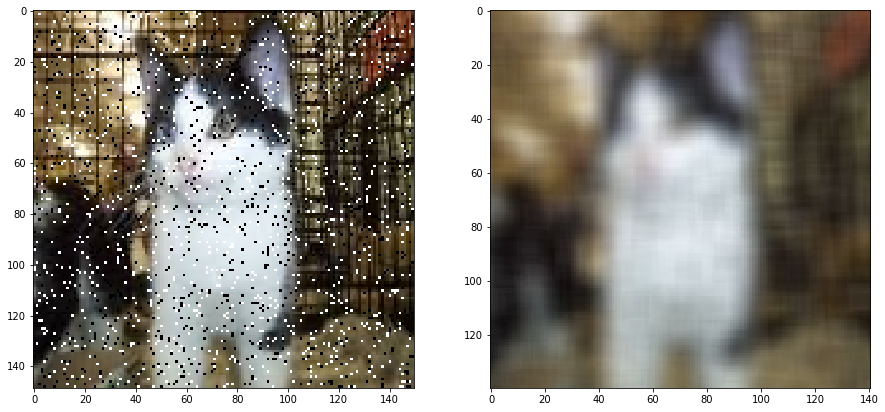

In [18]:
def noise(img, snr):
    h = img.shape[0]
    w = img.shape[1]
    img1 = img.copy()
    num = int(h * w * (1 - snr))
    for i in range (num):
        randx = np.random.randint(0, h)
        randy = np.random.randint(0, w)
        if np.random.random()<=0.5:
            img1[randx,randy]=0
        else:
            img1[randx,randy]=255
    return img1

img = cv2.imread('./images/a.png', 1)
img_n = noise(img, 0.9)
# cv2.imshow('n', img_n)
plt.figure(figsize=(15,15))
plt.subplot(121)
show_image(img_n)
kernel = (1/100) * np.ones((10, 10))
img_blur = Conv(img_n, kernel).astype(np.uint8)
plt.subplot(122)
show_image(img_blur)
# cv2.imshow('b', img_blur)
# key = cv2.waitKey()
# if key == 27:
#     cv2.destroyAllWindows()

### 4.3.2 高斯滤波

**应用：** 高斯滤波是一种线性平滑滤波器，对于服从正态分布的噪声有很好的抑制作用。在实际场景中，我们通常会假定图像包含的噪声为高斯白噪声，所以在许多实际应用的预处理部分，都会采用高斯滤波抑制噪声，如传统车牌识别等。

高斯滤波和均值滤波一样，都是利用一个掩膜和图像进行卷积求解。不同之处在于：均值滤波器的模板系数都是相同的，而高斯滤波器的模板系数，则随着距离模板中心的增大而系数减小（服从二维高斯分布）。所以，高斯滤波器相比于均值滤波器对图像个模糊程度较小，更能够保持图像的整体细节。

二维高斯分布

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200412165241878.png"/></div>     

其中不必纠结于系数，因为它只是一个常数！并不会影响互相之间的比例关系，并且最终都要进行归一化，所以在实际计算时我们是忽略它而只计算后半部分:

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200412165426976.png"/></div>     

其中(x,y)为掩膜内任一点的坐标，(ux,uy)为掩膜内中心点的坐标，在图像处理中可认为是整数；σ是标准差。

例如：要产生一个3×3的高斯滤波器模板，以模板的中心位置为坐标原点进行取样。模板在各个位置的坐标，如下所示（x轴水平向右，y轴竖直向下）。  

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200412165500464.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MDY0NzgxOQ==,size_16,color_FFFFFF,t_70"/></div>     

这样，将各个位置的坐标带入到高斯函数中，得到的值就是模板的系数。

**生成高斯掩膜（小数形式）**  
知道了高斯分布原理，实现起来也就不困难了。

首先我们要确定我们生产掩模的尺寸wsize，然后设定高斯分布的标准差。生成的过程，我们首先根据模板的大小，找到模板的中心位置center。 然后就是遍历，根据高斯分布的函数，计算模板中每个系数的值。

最后模板的每个系数要除以所有系数的和。这样就得到了小数形式的模板。由于中心点为（0, 0）点，故公式变为：

$$f(x, y) = e^{-\frac{x^2 + y^2}{2\sigma ^2}}$$


**3×3,σ=0.8的小数型模板：**   

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200412165756162.png"/></div>     




In [20]:
import numpy as np

def imgGaussian(ksize, sigma):
    '''
    :ksize：卷积核大小，必须是奇数
    :param sigma: σ标准差
    :return: 高斯滤波器的模板
    '''
    assert ksize%2 == 1
    gaussian_mat = np.zeros((ksize, ksize))
    k = int(ksize/2)
    for x in range(-k, k+1):
        for y in range(-k, k + 1):
            gaussian_mat[x + k][y + k] = np.exp(- (x ** 2 + y ** 2) / (2 * sigma ** 2))
    return gaussian_mat / gaussian_mat.sum()

**σ的意义及选取**   
通过上述的实现过程，不难发现，高斯滤波器模板的生成最重要的参数就是高斯分布的标准差σ。标准差代表着数据的离散程度，如果σ较小，那么生成的模板的中心系数较大，而周围的系数较小，这样对图像的平滑效果就不是很明显；反之，σ较大，则生成的模板的各个系数相差就不是很大，比较类似均值模板，对图像的平滑效果比较明显。

来看下一维高斯分布的概率分布密度图：

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200412165824372.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MDY0NzgxOQ==,size_16,color_FFFFFF,t_70"/></div>     
<div align=center><img   src ="https://pic3.zhimg.com/v2-2aa7aa2e36b9f85199aeb911f0413c2a_r.jpg"/></div>   
 

于是我们有如下结论：σ越小分布越瘦高，σ越大分布越矮胖。

* σ越大，分布越分散，各部分比重差别不大，于是生成的模板各元素值差别不大，类似于平均模板；
* σ越小，分布越集中，中间部分所占比重远远高于其他部分，反映到高斯模板上就是中心元素值远远大于其他元素值，于是自然而然就相当于中间值的点运算。

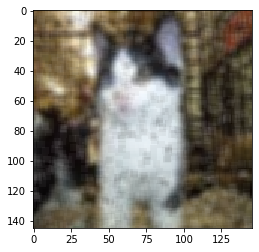

In [22]:
kernel = imgGaussian(5, 7)
img_b = Conv(img_n, kernel, padding=0).astype(np.uint8)  # 高斯模糊
show_image(img_b)
# cv2.imshow('b', img_b)
# key = cv2.waitKey()
# if key == 27:
#     cv2.destroyAllWindows()

## 4.4 非线性滤波

### 4.4.1 中值滤波

中值滤波是一种典型的非线性滤波，是基于排序统计理论的一种能够有效抑制噪声的非线性信号处理技术，基本思想是用像素点邻域灰度值的中值来代替该像素点的灰度值，让周围的像素值接近真实的值从而消除孤立的噪声点。该方法在取出脉冲噪声、椒盐噪声的同时能保留图像的边缘细节。这些优良特性是线性滤波所不具备的。

中值滤波首先也得生成一个滤波模板，将该模板内的各像素值进行排序，生成单调上升或单调下降的二维数据序列，二维中值滤波输出为


<div align=center><img   src ="https://img-blog.csdnimg.cn/2020042802014220.png"/></div>    

<div align=center><img   src ="https://img-blog.csdnimg.cn/20200428021512767.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQ0MzE1OTg3,size_16,color_FFFFFF,t_70"/></div>  

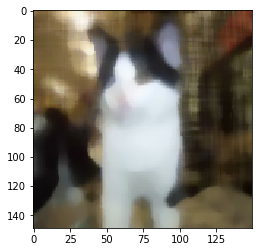

In [23]:
img_b = cv2.medianBlur(img_n, 9)
show_image(img_b)
# cv2.imshow('b', img_b);
# key = cv2.waitKey()
# if key == 27:
#     cv2.destroyAllWindows()

### 4.4.2 双边滤波

高斯滤波是最常用的图像去噪方法之一，它能很好地滤除掉图像中随机出现的高斯噪声，但是在之前的博客中提到过，高斯滤波是一种低通滤波，它在滤除图像中噪声信号的同时，也会对图像中的边缘信息进行平滑，表现出来的结果就是图像变得模糊，如下图所示；
<div align=center><img   src ="https://img-blog.csdnimg.cn/20181126110250403.jpg?#pic_center" width=300/></div> 

 高斯滤波之所以会导致图像变得模糊，是因为它在滤波过程中只关注了位置信息；即在滤波窗口内，距离中心点越近的点的权重越大；这种只关注距离的思想在某些情况下是可行的，例如在平坦的区域，距离越近的区域其像素分布也越相近，自然地，这些点的像素值对滤波中心点的像素值更有参考价值。但是在像素值出现跃变的边缘区域，这种方法会适得其反，损失掉有用的边缘信息。此时就出现了一类算法——边缘保护滤波方法，双边滤波就是最常用的边缘保护滤波方法。


双边滤波器的好处是可以做边缘保存（edge preserving），一般过去用的维纳滤波或者高斯滤波去降噪，都会较明显地模糊边缘，对于高频细节的保护效果并不明显。双边滤波器顾名思义比高斯滤波多了一个高斯方差sigma－d，它是基于空间分布的高斯滤波函数，所以在边缘附近，离的较远的像素不会太多影响到边缘上的像素值，这样就保证了边缘附近像素值的保存。

在双边滤波器中，输出像素的值依赖于邻域像素值的加权值组合：

<div align=center><img   src ="./images/Bilateral1.png" width=300/></div>    

而加权系数w(i,j,k,l)取决于定义域核和值域核的乘积。

其中定义域核表示如下（如图）：

<div align=center><img   src ="./images/bilateral2.png" width=300/></div>    

值域核表示为：

<div align=center><img   src ="./images/bilateral3.png" width=300/></div>    

两者相乘后，就会产生依赖于数据的双边滤波权重函数：

<div align=center><img   src ="./images/bilateral4.png" width=300/></div>    


<div align=center><img   src ="./images/2.png" width=1500/></div>

双边滤波OpenCV实现

  在OpenCV中已经有编辑好的双边滤波的函数；

void bilateralFilter( InputArray src, OutputArray dst, int d,
                                   double sigmaColor, double sigmaSpace,
                                   int borderType = BORDER_DEFAULT );


函数中的参数依次表示src：输入图像，dst: 输出图像，d：滤波窗口的直径（函数注释中使用的是Diameter，那么很可能函数中选取的窗口是圆形窗口），sigmaColor：像素值域方差，sigmaSpace：空间域方差，以及边缘处理方式。
参数：

 第一个参数，InputArray类型的src，输入图像，即源图像，需要为8位或者浮点型单通道、三通道的图像。    
 第二个参数，OutputArray类型的dst，即目标图像，需要和源图片有一样的尺寸和类型。     
 第三个参数，int类型的d，表示在过滤过程中每个像素邻域的直径。如果这个值我们设其为非正数，那么OpenCV会从第五个参数sigmaSpace来计算出它来。    
 第四个参数，double类型的sigmaColor，颜色空间滤波器的sigma值。这个参数的值越大，就表明该像素邻域内有更宽广的颜色会被混合到一起，产生较大的半相等颜色区域。   
 第五个参数，double类型的sigmaSpace坐标空间中滤波器的sigma值，坐标空间的标注方差。他的数值越大，意味着越远的像素会相互影响，从而使更大的区域足够相似的颜色获取相同的颜色。当d>0，d指定了邻域大小且与sigmaSpace无关。否则，d正比于sigmaSpace。第六个参数，int类型的borderType，用于推断图像外部像素的某种边界模式。注意它有默认值BORDER_DEFAULT。

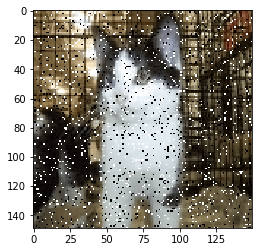

In [39]:
# h, w, c = img_n.shape[0], img_n.shape[1], img_n.shape[2]
# img_b = np.zeros((h,w,c))
img_b = cv2.bilateralFilter(img_n,0,15,100)
show_image(img_b)

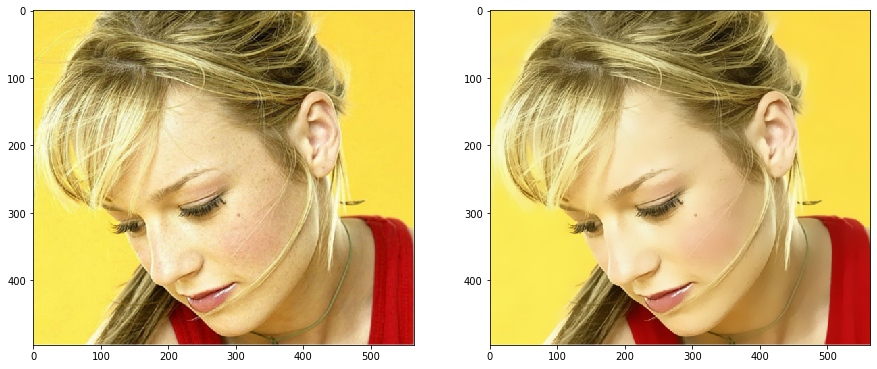

In [43]:
#美颜效果的实现
img_s = cv2.imread('images/1.png')
img_b = cv2.bilateralFilter(img_s,21,30,30) 
plt.figure(figsize=(15,15))
plt.subplot(121)
show_image(img_s)
plt.subplot(122)
show_image(img_b)

参考资料：https://github.com/datawhalechina/team-learning-cv/blob/master/ImageProcessingFundamentals/04%20%E5%9B%BE%E5%83%8F%E6%BB%A4%E6%B3%A2.md

# 06 边缘检测

## 6.1 简介

### 6.1.1 什么是边缘？

边缘是图像强度函数快速变化的地方

### 6.1.2 如何检测边缘？

为了检测边缘，我们需要检测图像中的**不连续性**，可以使用**导数**来检测不连续性。

![](https://img-blog.csdnimg.cn/20201101182927815.jpg)

如上图所示，上图的第一幅图表示一张数字图片，我们对水平红线处进行求导，便可得到上图二中的关系，可以看到在边缘处有着较大的跳变。但是，导数也会受到噪声的影响，因此建议在求导数之前先对图像进行平滑处理（上面）。

但是，导数也会受到噪声的影响，因此建议在求导数之前先对图像进行平滑处理。 然后我们可以使用遮罩使用卷积来检测边缘。 同样，我不打算讨论数学部分，这里我们仅关注实现细节。

## 6.2 目标

- Sobel边缘检测的原理
- Canny边缘检测的原理

## 6.3 内容介绍

1. Sobel,Canny算子介绍
2. OpenCV 代码实践


## 6.4 算法理论介绍与推荐

### 6.4.1 Sobel算子


我们可以使用$3 \times 3$ 的卷积核来进行图像求导：  

$$
{\displaystyle \mathbf {G}'_{y}={ \begin{bmatrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{bmatrix}}*\mathbf {I} \quad {\mbox{和}}\quad \mathbf{G}'_{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}*\mathbf {I} }
$$

其中$ \mathbf {I}$表示原图片，$\mathbf {G}'_{x}$和$\mathbf {G}'_{y}$分别表示沿图片水平和竖直方向上的变化，$ * $表示卷积操作

【例1】下面以Sobel算子为例讲述如何计算梯度

x和y方向的Sobel算子分别为：   

$$
\begin{equation}G_{x}=\left[\begin{array}{ccc}-1 & 0 & 1 \\-2 & 0 & 2 \\-1 & 0 & 1\end{array}\right] \quad G_{y}=\left[\begin{array}{ccc}1 & 2 & 1 \\0 & 0 & 0 \\-1 & -2 & -1\end{array}\right]\end{equation}
$$

若图像$\mathbf {G}$中一个3x3的窗口为A，要计算梯度的像素点为e，则和Sobel算子进行卷积之后，像素点e在x和y方向的梯度值分别为：  

$$
\begin{equation}\begin{aligned}{G}'_{x}=G_{x} * A=\left[\begin{array}{ccc}-1 & 0 & 1 \\-2 & 0 & 2 \\-1 & 0 & 1\end{array}\right] *\left[\begin{array}{ccc}a & b & c \\d & e & f \\g & h & i\end{array}\right]=\operatorname{sum}\left(\left[\begin{array}{ccc}-a & 0 & c \\-2 d & 0 & 2 f \\-g & 0 & i\end{array}\right]\right) \\{G}'_{y}=G_{y} * A=\left[\begin{array}{ccc}1 & 2 & 1 \\0 & 0 & 0 \\-1 & -2 & -1\end{array}\right] *\left[\begin{array}{ccc}a & b & c \\d & e & f \\g & h & i\end{array}\right]=\operatorname{sum}\left(\left[\begin{array}{ccc}a & 2 b & c \\0 & 0 & 0 \\-g & -2 h & -i\end{array}\right]\right)\end{aligned}\end{equation}
$$

其中“ * ” 为卷积符号，sum表示矩阵中所有元素相加求和。

### 6.4.2 Canny边缘检测

Canny边缘检测于1986年由JOHN CANNY首次在论文《A Computational Approach to Edge Detection》中提出，就此拉开了Canny边缘检测算法的序幕。

Canny边缘检测是从不同视觉对象中提取有用的结构信息并大大减少要处理的数据量的一种技术，目前已广泛应用于各种计算机视觉系统。Canny发现，在不同视觉系统上对边缘检测的要求较为类似，因此，可以实现一种具有广泛应用意义的边缘检测技术。边缘检测的一般标准包括：

1.    以低的错误率检测边缘，也即意味着需要尽可能准确的捕获图像中尽可能多的边缘。
2.    检测到的边缘应精确定位在真实边缘的中心。
3.    图像中给定的边缘应只被标记一次，并且在可能的情况下，图像的噪声不应产生假的边缘。

为了满足这些要求，Canny使用了变分法。Canny检测器中的最优函数使用四个指数项的和来描述，它可以由高斯函数的一阶导数来近似。

在目前常用的边缘检测方法中，Canny边缘检测算法是具有严格定义的，可以提供良好可靠检测的方法之一。由于它具有满足边缘检测的三个标准和实现过程简单的优势，成为边缘检测最流行的算法之一。

完成一个Canny边缘检测算法可以分为以下四步：

| 高斯滤波                            | 目的                                   |
| ----------------------------------- | -------------------------------------- |
| 1.高斯滤波                          | 去噪声降低错误率                       |
| 2.计算梯度幅值和方向                | 估计每一点处的边缘强度与方向           |
| 3.非极大值抑制（NMS）               | 对Sobel、Prewitt等算子的结果进一步细化 |
| 4应用双阈值（Double-Threshold）检测 | 确定真实的和可能的边缘。               |

#### 1.高斯滤波

边缘检测结果容易受到图像噪声的影响，图片中一些噪声会大大影像边缘检测。因此为了使图像平滑，可以用高斯滤波器内核与图像进行卷积。 此步骤将使图像稍微平滑，以减少边缘检测器上明显噪声的影响。 

大小为$（2k + 1）×（2k + 1）$的高斯滤波器核的方程式为：


$$
{\displaystyle H_{ij}={\frac {1}{2\pi \sigma ^{2}}}\exp \left(-{\frac {(i-(k+1))^{2}+(j-(k+1))^{2}}{2\sigma ^{2}}}\right);1\leq i,j\leq (2k+1)}
$$


【例2】下面一个5×5高斯卷积核例子，用于创建相邻图像，$\sigma = 1.4$。 （*表示卷积运算。）
$$
\mathbf {B} ={\frac {1}{159}}{\begin{bmatrix}2&4&5&4&2\\4&9&12&9&4\\5&12&15&12&5\\4&9&12&9&4\\2&4&5&4&2\end{bmatrix}}*\mathbf {A} 
$$
注意，选择高斯核的大小会影响检测器的性能。 尺寸越大，检测器对噪声的灵敏度越低。 此外，随着高斯滤波器核大小的增加，用于检测边缘的定位误差将略有增加。一般5x5是一个比较不错的trade off。

#### 2.计算梯度强度和方向

进行高斯滤波后，图像中的边缘可以指向各个方向，接下来使用四个算子来检测图像中的水平、垂直和对角边缘。边缘检测的算子（如Roberts，Prewitt，Sobel等）返回水平$G_x$和垂直$G_y$方向的一阶导数值，由此便可以确定像素点的梯度$G$和方向$\theta$ 。
$$
\mathbf {G} ={\sqrt {{\mathbf {G} _{x}}^{2}+{\mathbf {G} _{y}}^{2}}} \tag{1}
$$

$$
\mathbf {\theta } =\operatorname {arctan} \left(\mathbf {G} _{y}/\mathbf {G} _{x}\right) \tag{2}
$$

其中$\mathbf {G}$为梯度强度， $\theta$表示梯度方向，$\operatorname {arctan}$为反正切函数。通过上式我们可以得到一个梯度矩阵$\mathbf {G}$和方向矩阵 $\theta$。



【例3】角度的计算

见下图，假设 $\theta$有四条线，分别是0，45，90，135度线（0度和180重合，是一条线）。需要通过（2）式求出的$\theta$进行近似，分类到这四条线或四个角度中。

比如计算出的$\theta=91 $度,则应将其归类到90--270度方向

![](https://img-blog.csdnimg.cn/20201101183006863.png)

#### 3.非极大值抑制(NMS)

在每一点上，邻域中心与沿着其对应的梯度方向的两个像素相比，若中心像素为最大值，则保留，否则中心置0，这样可以抑制非极大值，保留局部梯度最大的点，以得到细化的边缘。

对图像进行梯度计算后，仅仅基于梯度值提取的边缘仍然很模糊。对边缘有且应当只有一个准确的响应。而非极大值抑制则可以帮助将局部最大值之外的所有梯度值抑制为0。非极大值抑制是一种边缘稀疏技术，非极大值抑制的作用在于“瘦”边。直观上地看，对第二步得到的图片，边缘由粗变细了。   
<div align=center><img src='images/3.png' width=300> </div>

#### 4. 用双阈值算法检测和连接边缘 

一张图解释双阈值算法检测：

![](https://img-blog.csdnimg.cn/20201101183035978.png)

双阈值法非常简单，我们假设两类边缘：经过非极大值抑制之后的边缘点中，**梯度值超过TH的称为强边缘，梯度值小于TH大于TL的称为弱边缘，梯度小于TL的不是边缘**。

可以肯定的是，强边缘必然是边缘点，因此必须将T1设置的足够高，以要求像素点的梯度值足够大（变化足够剧烈），而弱边缘可能是边缘，也可能是噪声，如何判断呢？**当弱边缘的周围8邻域有强边缘点存在时，就将该弱边缘点变成强边缘点**，以此来实现对强边缘的补充。实际中人们发现T1:T2=2:1的比例效果比较好，其中T1可以人为指定，也可以设计算法来自适应的指定，比如定义梯度直方图的前30%的分界线为T1。检查8邻域的方法叫边缘滞后跟踪，连接边缘的办法还有区域生长法等等。

## 6.5 基于OpenCV的实现

### 6.5.1 Sobel算子

opencv使用sobel 算子的方法是`cv2.Sobel`

```python
# -*- coding: utf-8 -*-
"""
cv2.Sobel(src, #参数是需要处理的图像；
					ddepth, #图像的深度，-1表示采用的是与原图像相同的深度。目标图像的深度必须大于等于原图像的深度
					dx, #dx和dy表示的是求导的阶数，0表示这个方向上没有求导，一般为0、1、2。
					dy[, 
					dst[, #输出图片
          ksize[,#Sobel算子的大小，必须为1、3、5、7。
          scale[, #缩放导数的比例常数，默认情况下没有伸缩系数；
          delta[, #可选的增量，将会加到最终的dst中，同样，默认情况下没有额外的值加到dst中；
          borderType #判断图像边界的模式。这个参数默认值为cv2.BORDER_DEFAULT。
          ]]]]])  
"""
import cv2
import numpy as np
from matplotlib import pyplot as plt

#读图
img = cv2.imread('IMG/test.jpg',0)

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

#画图
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()
```

结果：   

![](https://img-blog.csdnimg.cn/20201101183109709.png)

#### 6.5.2 Canny算法

```python
# -*- coding: utf-8 -*-

"""
cv2.Canny(image,            # 输入原图（必须为单通道图）
          threshold1,
          threshold2,       # 较大的阈值2用于检测图像中明显的边缘
          [, edges[,
          apertureSize[,    # apertureSize：Sobel算子的大小
          L2gradient ]]])   # 参数(布尔值)：
                              true： 使用更精确的L2范数进行计算（即两个方向的倒数的平方和再开放），
                              false：使用L1范数（直接将两个方向导数的绝对值相加）。
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

original_img = cv2.imread("IMG/test.jpg", 0)

# canny边缘检测
img1 = cv2.GaussianBlur(original_img,(3,3),0)
canny = cv2.Canny(img1, 50, 150)

# 画图
plt.subplot(1,2,1),plt.imshow(original_img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(canny,cmap = 'gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])
plt.show()
```

结果：

![](https://img-blog.csdnimg.cn/20201101183137178.png)

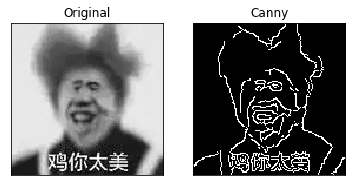

In [45]:
img_a = cv2.imread('images/ji.jpg',0)
# canny边缘检测
img1 = cv2.GaussianBlur(img_a,(3,3),0)
canny = cv2.Canny(img1, 50, 150)

# 画图
plt.subplot(1,2,1),plt.imshow(img_a,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(canny,cmap = 'gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])
plt.show()